# Identifying neighbourhood fingerprints: counterexamples from [Pozdnyakov et al., 2020](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.166001)

*Background:*
Geometric GNNs identify local neighbourhoods around nodes via **'neighbourhood finderprints'** or scalarisations, where local geometric information from subsets of neighbours is aggregated to compute invariant scalars. The number of neighbours involved in computing the scalars is termed the **body order**.
The ideal neighbourhood fingerprint would perfectly identify neighbourhoods, which requires arbitrarily high body order.

*Experiment:*
To demonstrate the practical implications of scalarisation body order, we evaluate geometric GNN layers on their ability to discriminate counterexamples from [Pozdnyakov et al., 2020](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.166001).
Each counterexample consists of a pair of local neighbourhoods that are **indistinguishable** when comparing their set of $k$-body scalars, i.e. geometric GNN layers with body order $k$ cannot distinguish the neighbourhoods.
The 3-body counterexample corresponds to Fig.1(b) in Pozdnyakov et al., 2020, 4-body chiral to Fig.2(e), and 4-body non-chiral to Fig.2(f); the 2-body counterexample is based on the two local neighbourhoods in our running example.
In this notebook, we train single layer geometric GNNs to distinguish the counterexamples using updated scalar features. 

![Counterexamples from Pozdnyakov et al., 2020](fig/incompleteness.png)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import numpy as np
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import is_undirected, to_undirected, remove_self_loops, to_dense_adj, dense_to_sparse
import e3nn
from e3nn import o3
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from src.utils.plot_utils import plot_2d, plot_3d
from src.utils.train_utils import run_experiment
from src.models import MPNNModel, EGNNModel, GVPGNNModel, TFNModel, SchNetModel, DimeNetPPModel, MACEModel

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version 1.12.1
PyG version 2.1.0
e3nn version 0.4.4
Using device: cpu


# Two-body counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $2$-body scalars, i.e. the unordered set of pairwise distances.

In [3]:
def create_two_body_envs():
    dataset = []

    # Environment 0
    # atoms = torch.LongTensor([ 0, 1, 2 ])
    atoms = torch.LongTensor([ 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0], [1, 2] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [5, 0, 0],
        [3, 0, 4]
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    # atoms = torch.LongTensor([ 0, 1, 2 ])
    atoms = torch.LongTensor([ 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0], [1, 2] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [5, 0, 0],
        [-5, 0, 0]
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

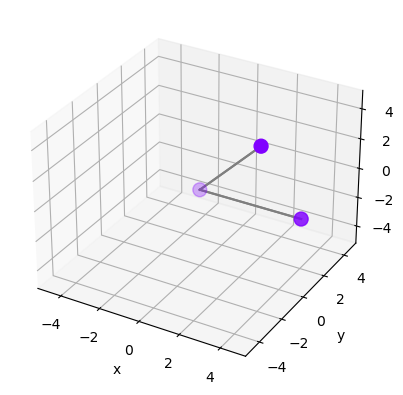

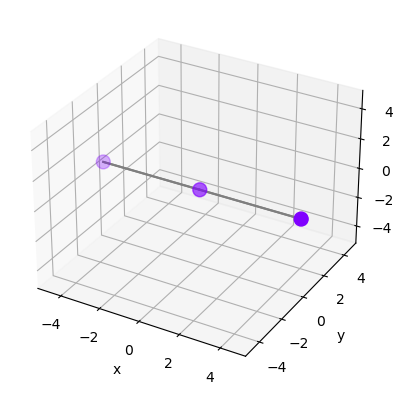

Running experiment for MACEModel (cpu).


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


Done! Averaged over 10 runs: 
 - Training time: 3.15s ± 0.13. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [5]:
# Create dataset
dataset = create_two_body_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Set model
model_name = "mace"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

num_layers = 1
correlation = 2
model = {
    "mpnn": MPNNModel,
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

# Three-body counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $3$-body scalars, i.e. the unordered set of pairwise distances as well as angles.

In [6]:
def create_three_body_envs():
    dataset = []

    a_x, a_y, a_z = 5, 0, 5
    b_x, b_y, b_z = 5, 5, 5
    c_x, c_y, c_z = 0, 5, 5
    
    # Environment 0
    # atoms = torch.LongTensor([ 0, 1, 2, 3, 4 ])
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a_x, a_y, a_z],
        [+b_x, +b_y, b_z],
        [-b_x, -b_y, b_z],
        [c_x, +c_y, c_z],
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    # atoms = torch.LongTensor([ 0, 1, 2, 3, 4 ])
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a_x, a_y, a_z],
        [+b_x, +b_y, b_z],
        [-b_x, -b_y, b_z],
        [c_x, -c_y, c_z],
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

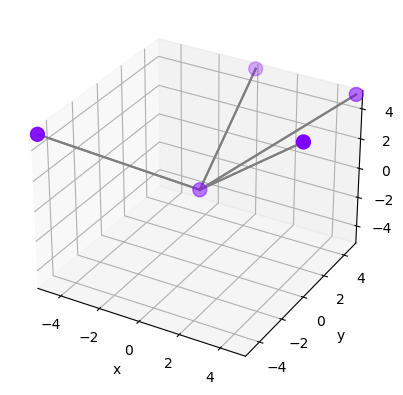

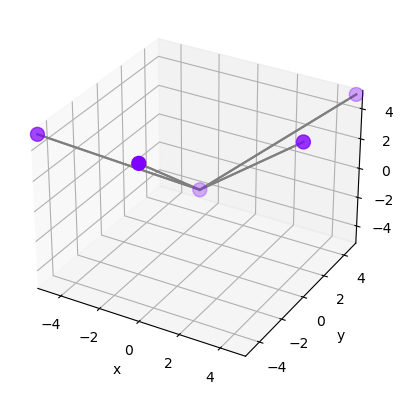

Running experiment for MACEModel (cpu).


100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


Done! Averaged over 10 runs: 
 - Training time: 5.45s ± 0.31. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



In [7]:
# Create dataset
dataset = create_three_body_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Set model
model_name = "mace"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

num_layers = 1
correlation = 3
model = {
    "mpnn": MPNNModel,
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

# Four-body non-chiral counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $4$-body scalars without considering chirality/handedness, i.e. the unordered set of pairwise distances, angles, and quadruplet scalars.

In [8]:
def create_four_body_nonchiral_envs():
    dataset = []

    a1_x, a1_y, a1_z = 3, 2, -4
    a2_x, a2_y, a2_z = 0, 2, 5
    a3_x, a3_y, a3_z = -3, 2, -4
    b1_x, b1_y, b1_z = 3, -2, -4
    b2_x, b2_y, b2_z = 0, -2, 5
    b3_x, b3_y, b3_z = -3, -2, -4
    c_x, c_y, c_z = 0, 5, 0

    angle = 2 * torch.pi / 10 # random angle
    Q = o3.matrix_y(torch.tensor(angle)).numpy()

    # Environment 0
    # atoms = torch.LongTensor([ 0, 1, 1, 1, 1, 1, 1, 2 ])
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0, 0, 0, 0], [1, 2, 3, 4, 5, 6, 7] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [b1_x, b1_y, b1_z] @ Q,
        [b2_x, b2_y, b2_z] @ Q,
        [b3_x, b3_y, b3_z] @ Q,
        [c_x, +c_y, c_z],
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    # atoms = torch.LongTensor([ 0, 1, 1, 1, 1, 1, 1, 2 ])
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0, 0, 0, 0], [1, 2, 3, 4, 5, 6, 7] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [b1_x, b1_y, b1_z] @ Q,
        [b2_x, b2_y, b2_z] @ Q,
        [b3_x, b3_y, b3_z] @ Q,
        [c_x, -c_y, c_z],
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

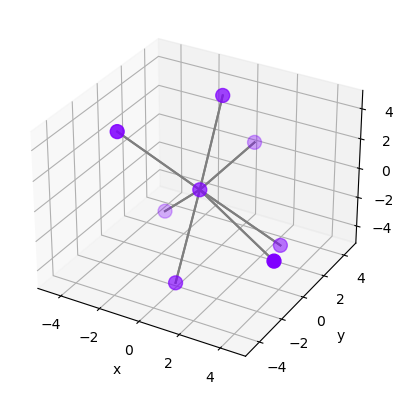

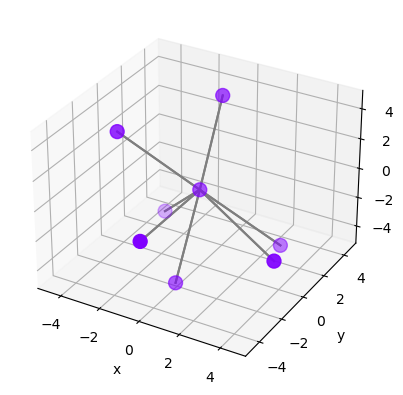

Running experiment for MACEModel (cpu).


100%|██████████| 10/10 [02:49<00:00, 17.00s/it]


Done! Averaged over 10 runs: 
 - Training time: 16.99s ± 0.36. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



In [11]:
# Create dataset
dataset = create_four_body_nonchiral_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Set model
model_name = "mace"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

num_layers = 1
correlation = 4
model = {
    "mpnn": MPNNModel,
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)

# Four-body chiral counterexample

Pair of local neighbourhoods that are indistinguishable when comparing their set of $4$-body scalars when considering chirality/handedness, i.e. the unordered set of pairwise distances, angles, and quadruplet scalars.

In [12]:
def create_four_body_chiral_envs():
    dataset = []

    a1_x, a1_y, a1_z = 3, 0, -4
    a2_x, a2_y, a2_z = 0, 0, 5
    a3_x, a3_y, a3_z = -3, 0, -4
    c_x, c_y, c_z = 0, 5, 0

    # Environment 0
    # atoms = torch.LongTensor([ 0, 1, 1, 1, 2 ])
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [c_x, +c_y, c_z],
    ])
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Environment 1
    # atoms = torch.LongTensor([ 0, 1, 1, 1, 2 ])
    atoms = torch.LongTensor([ 0, 0, 0, 0, 0 ])
    edge_index = torch.LongTensor([ [0, 0, 0, 0], [1, 2, 3, 4] ])
    pos = torch.FloatTensor([ 
        [0, 0, 0],
        [a1_x, a1_y, a1_z],
        [a2_x, a2_y, a2_z],
        [a3_x, a3_y, a3_z],
        [c_x, -c_y, c_z],
    ])
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

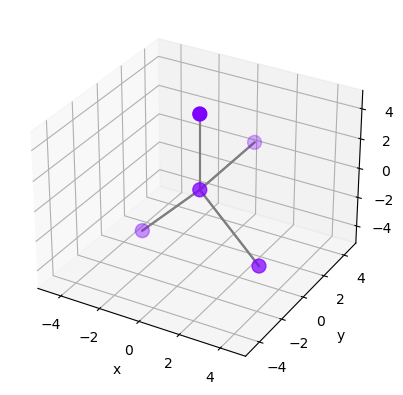

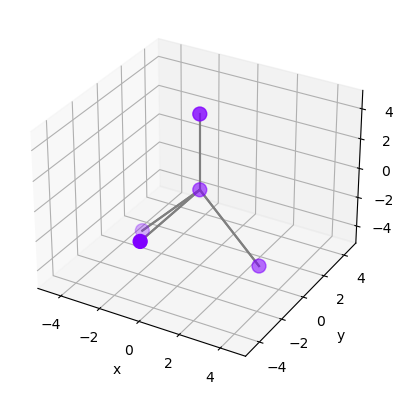

Running experiment for MACEModel (cpu).


100%|██████████| 10/10 [02:04<00:00, 12.41s/it]


Done! Averaged over 10 runs: 
 - Training time: 12.41s ± 0.38. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



In [13]:
# Create dataset
dataset = create_four_body_chiral_envs()
for data in dataset:
    plot_3d(data, lim=5)

# Set model
model_name = "mace"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

num_layers = 1
correlation = 4
model = {
    "mpnn": MPNNModel,
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "egnn": EGNNModel,
    "gvp": GVPGNNModel,
    "tfn": TFNModel,
    "mace": partial(MACEModel, correlation=correlation),
}[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

best_val_acc, test_acc, train_time = run_experiment(
    model, 
    dataloader,
    val_loader, 
    test_loader,
    n_epochs=100,
    n_times=10,
    device=device,
    verbose=False
)